In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tempfile
import os
tmpdir = tempfile.mkdtemp()
os.chdir(tmpdir)

In [3]:
pwd

u'/private/var/folders/0z/pfx_q1n149l2qcqc3dk6zg680000gp/T/tmpwTthtS'

In [4]:
import pandas as pd
from nomad.serialize import HDFSerializer
from persist import PersistentDAG

In [5]:
class HDFSerializer(object):
    def __init__(self, dirname):
        self.dirname = dirname

    def _filename(self, key):
        if not isinstance(key, (list, tuple)):
            key = [key]
        filename = os.path.join(self.dirname, *key)
        return filename
    
    def load(self, key):
        filename = self._filename(key)
        print "load data from file {}".format(filename)
        return pd.read_hdf(filename, 'data')

    def dump(self, key, value):
        filename = self._filename(key)
        print "dump data in file {}".format(filename)
        value.to_hdf(filename, 'data')

    def is_computed(self, key):
        return os.path.exists(self._filename(key))


In [6]:
serializer=HDFSerializer(tmpdir)
data =  pd.DataFrame({'A':[1,2], 'B':[3,4]})

cache = dict()
g = PersistentDAG(cache=cache)
f = lambda x: x
g.add_task(f, data, dask_serializer=serializer)


Delayed('lambda-dab8a814f46ce6639853afbca92afc50')

The first time the graph is called, data are computed and dumped on disk

In [7]:
result = g.compute()
result

dump data in file /var/folders/0z/pfx_q1n149l2qcqc3dk6zg680000gp/T/tmpwTthtS/lambda-dab8a814f46ce6639853afbca92afc50


,A,B
0,1,3
1,2,4


The second time they are loaded from disk

In [8]:
result = g.compute()
result

,A,B
0,1,3
1,2,4


In [9]:
cache

{'lambda-dab8a814f46ce6639853afbca92afc50':    A  B
 0  1  3
 1  2  4}

When get method is used, serialized keys are put in cache.

In [10]:
g.get()

(   A  B
 0  1  3
 1  2  4,)

In [11]:
cache

{'lambda-dab8a814f46ce6639853afbca92afc50':    A  B
 0  1  3
 1  2  4}

In [12]:
result = g.compute()
result

,A,B
0,1,3
1,2,4


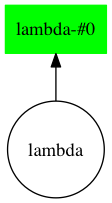

In [13]:
g.visualize()

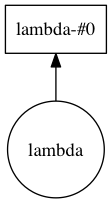

In [14]:
g.delayed(f)(data).visualize()

## delayed syntax 

We let's look at the usual dask delayed syntax

In [15]:
from dask import delayed
delayed(f)(data).compute()

,A,B
0,1,3
1,2,4


With PersistentDag, we can use:

In [16]:
cache = dict()
g = PersistentDAG(cache=cache)
f = lambda x: x
g.delayed(f)(data).compute()

,A,B
0,1,3
1,2,4


In [17]:
cache

{}

In [18]:
g.compute()

,A,B
0,1,3
1,2,4


In [19]:
cache

{'lambda-30edcbea2069b216fc02e0174d6faa0e':    A  B
 0  1  3
 1  2  4}